### Importing libraries

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Selective search function

In [2]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

### Intersection over union (not used)

In [ ]:
''''
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
''''

### Using annotation data 

In [3]:
def get_iou(bb1):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    x_left = bb1['x1']
    y_top = bb1['y1']
    x_right = bb1['x2']
    y_bottom = bb1['y2']
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    iou = intersection_area / float(bb1_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

### Drawing boxes around potholes, saving train images and labels

In [4]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir('AData_S/images')):
    try:
        filename = i.split(".")[0]+".jpg"
        #print(e,filename) 
        image = cv2.imread(os.path.join('AData_S/images',filename))
        df = pd.read_csv(os.path.join('AData_S/Data.csv'))
        gtvalues=[]
        for i in range(len(df)):
            x1 = df['x'][i]
            y1 = df['y'][i]
            x2 = df['x'][i] + df['width'][i]
            y2 = df['y'][i] + df['height'][i]
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval)
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
''''
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir('AData_S/images')):
    try:
        filename = i.split(".")[0]+".jpg"
        #print(e,filename) 
        image = cv2.imread(os.path.join('AData_S/images',filename))
        df = pd.read_csv(os.path.join('AData_S/Data.csv'))
        gtvalues=[]
        for i in range(len(df)):
            x1 = df['x'][i]
            y1 = df['y'][i]
            x2 = df['x'][i] + df['width'][i]
            y2 = df['y'][i] + df['height'][i]
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue
''''

### Conversion to numpy array

In [5]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

### Using VGG model

In [6]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

2023-02-17 18:55:51.758065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [8]:
X= vggmodel.layers[-2].output

In [9]:
predictions = Dense(2, activation="softmax")(X)

In [10]:
model_final = Model(vggmodel.input,predictions)

In [11]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [13]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Not sure if this is required

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [15]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


/var/folders/7c/s_44qy7x2xl31y_8nm69xyg80000gn/T/ipykernel_70235/883315946.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.00000, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 35s 4s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
10/10 [==============================] - 34s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00000
10/10 [==============================] - 35s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: val_loss did not i

### Loading our CNN model

In [17]:
model = tf.keras.models.load_model('Model/weights.24-0.86.hdf5')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [19]:
#hist = model.fit_generator(traindata, epochs= 10, validation_data= testdata)
hist= model.fit_generator(traindata,validation_data = testdata, steps_per_epoch = 10,epochs = 10)
    
    

/var/folders/7c/s_44qy7x2xl31y_8nm69xyg80000gn/T/ipykernel_70235/2728992085.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist= model.fit_generator(traindata,validation_data = testdata, steps_per_epoch = 10,epochs = 10)


Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node 'Squeeze' defined at (most recent call last):
    File "/Applications/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Applications/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Applications/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Applications/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Applications/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Applications/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Applications/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/7c/s_44qy7x2xl31y_8nm69xyg80000gn/T/ipykernel_70235/2728992085.py", line 2, in <module>
      hist= model.fit_generator(traindata,validation_data = testdata, steps_per_epoch = 10,epochs = 10)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 646, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/metrics/metrics.py", line 3327, in sparse_categorical_accuracy
      matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Applications/anaconda3/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 885, in sparse_categorical_matches
      y_true = tf.squeeze(y_true, [-1])
Node: 'Squeeze'
Can not squeeze dim[1], expected a dimension of 1, got 2
	 [[{{node Squeeze}}]] [Op:__inference_train_function_3251]

1/1 [==============================] - 0s 113ms/step
Number of potholes : 10


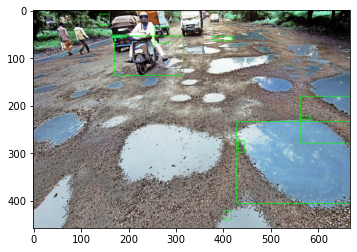

In [20]:
z=0
count = 0
for e,i in enumerate(os.listdir('AData_S/test')):
    z += 1
    img = cv2.imread(os.path.join('AData_S/test',i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for e,result in enumerate(ssresults):
        if e < 10:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model_final.predict(img)
            if out[0][1] > 0.70:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                count += 1
    print("Number of potholes :",count)
    plt.figure()
    plt.imshow(imout)
    break